In [1]:
import os
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

SEED=42
os.environ["PYTHONHASHSEED"]=str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# GPU 설정
gpus=tf.config.experimental.list_physical_devices("GPU")
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE=224
BATCH_SIZE=32
DATA_PATH="../../data/processed/04_kaggle_dataset"

datagen=ImageDataGenerator(
    rescale=1./255,
    rotation_range=5,
    zoom_range=0.1,
    brightness_range=[0.8, 1.2],
    width_shift_range=0.1,
    height_shift_range=0.1,
    fill_mode="nearest",
    validation_split=0.2
)

train_generator=datagen.flow_from_directory(
    DATA_PATH,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    color_mode="rgb",
    class_mode="binary",
    subset="training",
    shuffle=True,
    seed=SEED
)

val_generator=datagen.flow_from_directory(
    DATA_PATH,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    color_mode="rgb",
    class_mode="binary",
    subset="validation",
    shuffle=False,
    seed=SEED
)

2025-06-17 21:55:12.331336: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-17 21:55:12.823182: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-06-17 21:55:12.823303: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-06-17 21:55:12.905282: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-17 21:55:13.075264: I tensorflow/core/platform/cpu_feature_guar

Found 8032 images belonging to 2 classes.
Found 2007 images belonging to 2 classes.


In [4]:
base_model=EfficientNetB0(weights="imagenet", include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable=True

# Sequential 모델 정의
model=Sequential([
    base_model,
    GlobalAveragePooling2D(),
    BatchNormalization(),
    Dropout(0.3),
    Dense(1, activation="sigmoid")
])

model.compile(optimizer=Adam(learning_rate=1e-5), loss="binary_crossentropy", metrics=["accuracy"])
model_path="../../src/models/21_efficientnetb0/best_model.keras"
mcp=ModelCheckpoint(model_path, monitor="val_loss", save_best_only=True, verbose=1)
es=EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True, verbose=1)
reducelr=ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, verbose=1)

In [5]:
history=model.fit(train_generator, validation_data=val_generator,
                  epochs=20, callbacks=[es, reducelr, mcp])

Epoch 1/20


2025-06-17 22:06:22.873723: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/efficientnetb0/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


251/251 [==============================] - ETA: 0s - loss: 0.4759 - accuracy: 0.7794
Epoch 1: val_loss improved from inf to 0.98043, saving model to ../../src/models/21_efficientnetb0/best_model.keras
251/251 [==============================] - 101s 338ms/step - loss: 0.4759 - accuracy: 0.7794 - val_loss: 0.9804 - val_accuracy: 0.4983 - lr: 1.0000e-05
Epoch 2/20
251/251 [==============================] - ETA: 0s - loss: 0.2540 - accuracy: 0.9044
Epoch 2: val_loss improved from 0.98043 to 0.25810, saving model to ../../src/models/21_efficientnetb0/best_model.keras
251/251 [==============================] - 84s 336ms/step - loss: 0.2540 - accuracy: 0.9044 - val_loss: 0.2581 - val_accuracy: 0.9133 - lr: 1.0000e-05
Epoch 3/20
251/251 [==============================] - ETA: 0s - loss: 0.2120 - accuracy: 0.9231
Epoch 3: val_loss did not improve from 0.25810
251/251 [==============================] - 84s 335ms/step - loss: 0.2120 - accuracy: 0.9231 - val_loss: 0.3525 - val_accuracy: 0.8590 - l

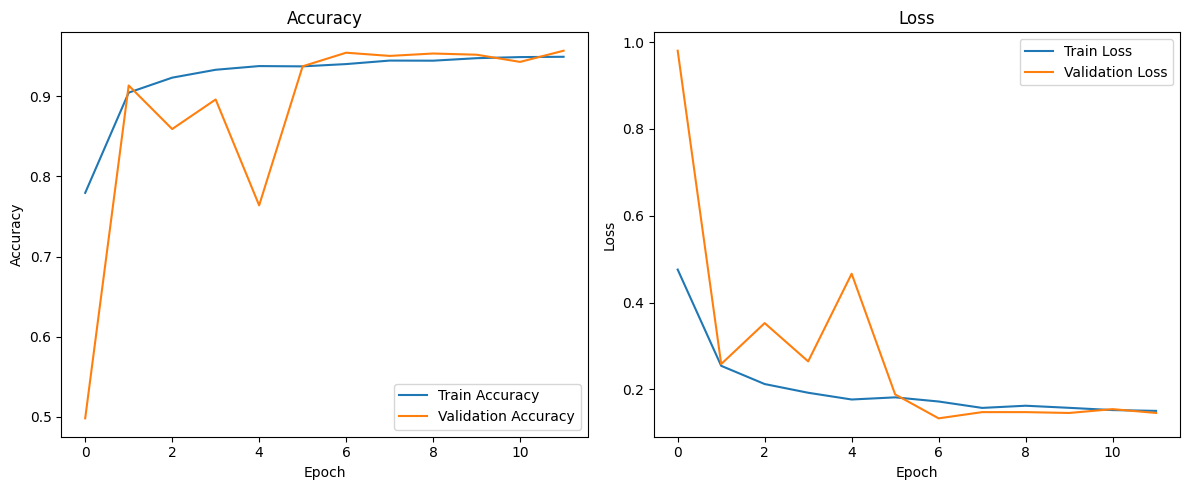

In [6]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.savefig("../../results/images/21_efficientnetb0_training_plot.png")
plt.show()

In [7]:
y_true=val_generator.classes
steps=val_generator.samples // val_generator.batch_size + 1
y_pred_prob=model.predict(val_generator, steps=steps, verbose=0)
y_pred=(y_pred_prob > 0.5).astype(int)

report=classification_report(y_true, y_pred, target_names=["closed", "open"])
print("=== Classification Report ===")
print(report)

report_path="../../results/reports/21_efficientnetb0_classification_report.txt"
with open(report_path, "w") as f:
    f.write(report)

=== Classification Report ===
              precision    recall  f1-score   support

      closed       0.94      0.96      0.95      1000
        open       0.96      0.94      0.95      1007

    accuracy                           0.95      2007
   macro avg       0.95      0.95      0.95      2007
weighted avg       0.95      0.95      0.95      2007



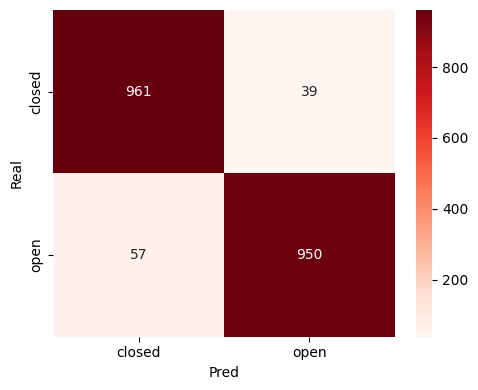

In [8]:
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Reds",
            xticklabels=["closed", "open"], yticklabels=["closed", "open"])
plt.xlabel("Pred")
plt.ylabel("Real")
plt.tight_layout()
plt.savefig("../../results/images/21_efficientnetb0_confusion_matrix.png")
plt.show()

# ❗ best성능